In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as nnf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

torch.set_default_dtype(torch.float64)

In [2]:
def is_array(X):
    return isinstance(X, (list, tuple, np.ndarray))

In [3]:
degree = 3
K = torch.tensor([i for i in range(degree)], dtype=torch.float64)

def basis_cos(x):
    if is_array(x):
        return np.cos(np.outer(K, x))
    
    if torch.is_tensor(x):
        return torch.cos(torch.ger(K, x))
    
    return np.cos(x * K)

def basis_sin(x):
    if is_array(x):
        return np.sin(np.outer(K, x))
    
    if torch.is_tensor(x):
        return torch.sin(torch.ger(K, x))
    
    return np.cos(x * K)

class FourierFunction:
    
    def __init__(self, A, B):
        if len(A) != len(K) or len(B) != len(K):
            raise ValueError("Invalid input shape")
        
        self.A = A
        self.B = B
    
    def compute(self, X):
        return (self.A @ basis_cos(X)) + (self.B @ basis_sin(X))
    
    def derive1(self, X):
        return ((self.B * K) @ basis_cos(X)) - ((self.A * K) @ basis_sin(X))
    
    def derive2(self, X):
        return -((self.A * (K**2)) @ basis_cos(X)) - ((self.B * (K**2)) @ basis_sin(X))
    
    def derive3(self, X):
        return -((self.B * (K**3)) @ basis_cos(X)) + ((self.A * (K**3)) @ basis_sin(X))
    
    def derive4(self, X):
        return ((self.A * (K**4)) @ basis_cos(X)) + ((self.B * (K**4)) @ basis_sin(X))



In [4]:
def generate_coefficients():
    lim = 10
    sigma = 0.1
    a, b = -lim/sigma, +lim/sigma 
    A = sigma * truncnorm.rvs(a, b, size=degree)
    B = sigma * truncnorm.rvs(a, b, size=degree)
    return torch.from_numpy(A), torch.from_numpy(B)

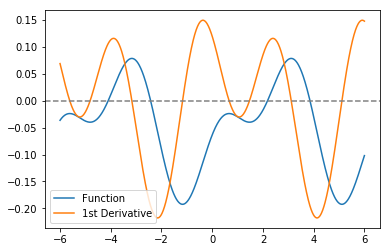

In [5]:
# Test FourierFunction and its derivatives
debug_func = True
X = torch.linspace(-6, 6, 1000)
if debug_func:
    A, B = generate_coefficients()
    func = FourierFunction(A, B)
    plt.plot(X.numpy(), func.compute(X).numpy(), label="Function")
    plt.plot(X.numpy(), func.derive1(X).numpy(), label="1st Derivative")
    plt.axhline(color='gray', linestyle='--')
    plt.legend()
    plt.show()

In [ ]:
class DerivativeNet(nn.Module):

    def __init__(self):
        super(DerivativeNet, self).__init__()
        self.fct1 = nn.Linear(1000, 10_000)
        self.fct2 = nn.Linear(10_000, 10_000)
        self.fct3 = nn.Linear(10_000, 4000)

    def forward(self, x):
        x = torch.tanh(self.fct1(x))
        x = torch.tanh(self.fct2(x))
        x = self.fct3(x)
        return x

In [15]:
net = DerivativeNet()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001)

# in your training loop:
for epoch in range(10_000):
    A, B = generate_coefficients()
    func = FourierFunction(A, B)
    target = torch.cat((func.derive1(X), func.derive2(X), func.derive3(X), func.derive4(X)))
    
    optimizer.zero_grad()
    output = net(func.compute(X))
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print("Epoch "+str(epoch)+": "+("%.2f" % loss.data.item()))

Epoch 0: 0.19
Epoch 20: 0.16
Epoch 40: 0.66
Epoch 60: 0.15
Epoch 80: 0.65
Epoch 100: 1.71
Epoch 120: 0.50
Epoch 140: 2.51
Epoch 160: 0.07
Epoch 180: 1.70
Epoch 200: 0.53
Epoch 220: 2.37
Epoch 240: 0.24
Epoch 260: 1.05
Epoch 280: 0.22
Epoch 300: 0.35
Epoch 320: 2.26
Epoch 340: 1.01
Epoch 360: 1.14
Epoch 380: 1.22
Epoch 400: 0.66
Epoch 420: 1.26
Epoch 440: 0.07
Epoch 460: 0.87
Epoch 480: 1.99
Epoch 500: 1.78
Epoch 520: 0.36
Epoch 540: 0.02
Epoch 560: 1.04
Epoch 580: 0.94
Epoch 600: 0.73
Epoch 620: 0.27
Epoch 640: 0.25
Epoch 660: 1.31
Epoch 680: 0.90
Epoch 700: 0.38
Epoch 720: 0.06
Epoch 740: 0.26
Epoch 760: 0.33
Epoch 780: 0.09
Epoch 800: 0.09
Epoch 820: 0.40
Epoch 840: 0.07
Epoch 860: 0.21
Epoch 880: 0.51
Epoch 900: 2.88
Epoch 920: 0.82
Epoch 940: 0.24


KeyboardInterrupt: 